In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Jupiter magic command, read above
%matplotlib inline

### ES - September 19, 2000 to July 11, 2022

In [2]:
df = pd.read_csv('../data/Yahoo_ES_daily_20000919_20220711.csv')
df[:9]

,Date,Close
0,2022-07-11,3856.75
1,2022-07-08,3901.25
2,2022-07-07,3905
3,2022-07-06,3848.25
4,2022-07-05,3834
5,2022-07-04,-
6,2022-07-01,3827.25
7,2022-06-30,3789.5
8,2022-06-29,3821.25


In [3]:
df.tail()

,Date,Close
5549,2000-09-25,1461
5550,2000-09-22,1468.5
5551,2000-09-21,1469.5
5552,2000-09-20,1469.5
5553,2000-09-19,1478.5


In [4]:
# Dates are a string right now
print(type(df['Date'][0]))
# Convert to date Timestamp
df['Date'] = pd.to_datetime(df['Date'])
print(type(df['Date'][0]))

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [5]:
# Holidays show '-' as a value, like July 4h. We want to fill those rows with the average value of the previous day and the day after.

# Convert column 'Data' to numeric, setting invalid values to NaN
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
# Fill NaN values with the average value of the previous day and the day after.
df['Close'] = df['Close'].interpolate(method='linear')
df[:9]

,Date,Close
0,2022-07-11,3856.750
1,2022-07-08,3901.250
2,2022-07-07,3905.000
3,2022-07-06,3848.250
4,2022-07-05,3834.000
5,2022-07-04,3830.625
6,2022-07-01,3827.250
7,2022-06-30,3789.500
8,2022-06-29,3821.250


In [6]:
# We want to sort the dataframe in ascending Dates and reset the index
df = df.sort_values(by='Date').reset_index(drop=True) 
df[:9]

,Date,Close
0,2000-09-19,1478.50
1,2000-09-20,1469.50
2,2000-09-21,1469.50
3,2000-09-22,1468.50
4,2000-09-25,1461.00
5,2000-09-26,1443.00
6,2000-09-27,1446.75
7,2000-09-28,1476.00
8,2000-09-29,1454.00


In [7]:
df[-9:]

,Date,Close
5545,2022-06-29,3821.250
5546,2022-06-30,3789.500
5547,2022-07-01,3827.250
5548,2022-07-04,3830.625
5549,2022-07-05,3834.000
5550,2022-07-06,3848.250
5551,2022-07-07,3905.000
5552,2022-07-08,3901.250
5553,2022-07-11,3856.750


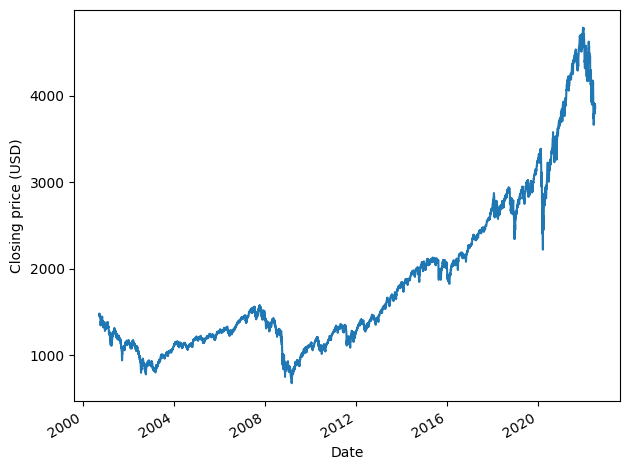

In [8]:
# ES - September 19, 2000 to July 11, 2022

fig, ax = plt.subplots()

ax.plot(df['Date'], df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')

fig.autofmt_xdate()
plt.tight_layout()

In [9]:
# Testing for Stationarity
ADF_result = adfuller(df['Close'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
# ADF Statistic = 0.67 (is not a large negative number) and p-value = 0.99 (greater than 0.05), thus we cannot reject the null hypothesis (non-stationarity), 
# thus the ES series is non-stationary

ADF Statistic: 0.673452388920053
p-value: 0.9892928998871603


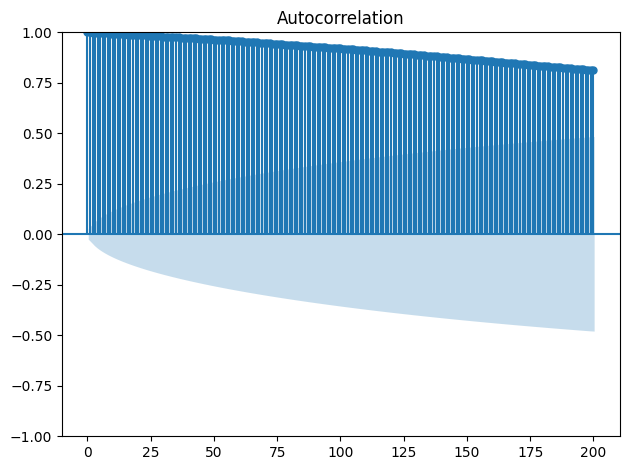

In [10]:
# ACF plot does not apply, but interesting how it does keep showing correlation all the way in a non-stationary process

plot_acf(df['Close'], lags=200)

plt.tight_layout()

In [11]:
# First-order differencing

first_order_diff = np.diff(df['Close'], n=1)

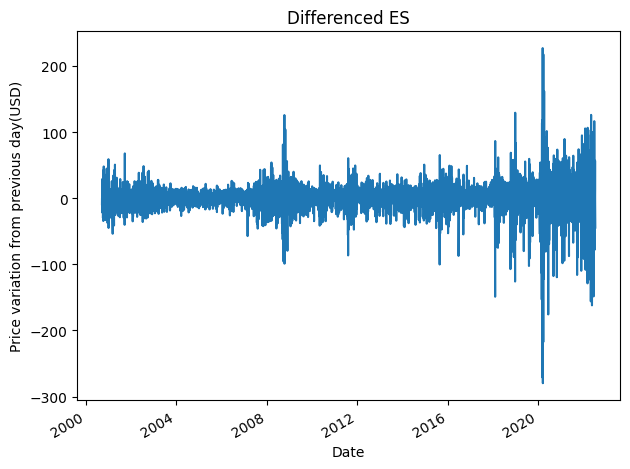

In [12]:
# First-order differencing plot

fig, ax = plt.subplots()

ax.plot(df['Date'][1:], first_order_diff)
ax.set_xlabel('Date')
ax.set_ylabel('Price variation from previous day(USD)')

plt.title('Differenced ES')
fig.autofmt_xdate()
plt.tight_layout()

In [13]:
# Testing for Stationarity
ADF_result = adfuller(first_order_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
# ADF Statistic = -15.15 (is a large negative number) and p-value = 0.00 (smaller than 0.05), thus we can reject the null hypothesis (non-stationarity), 
# thus the first-order differencing of ES series is stationary

ADF Statistic: -15.15053515517655
p-value: 6.807310190122213e-28


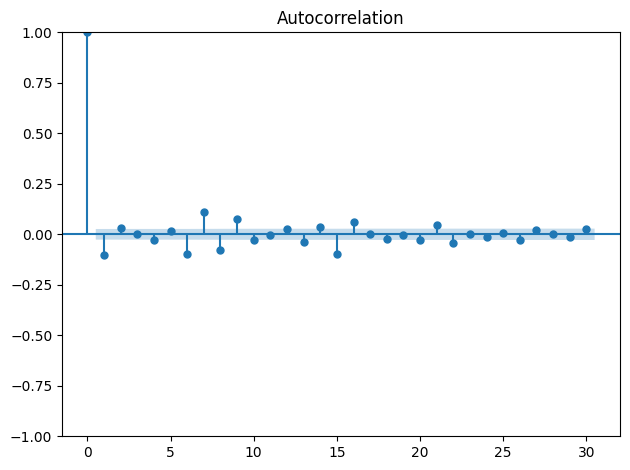

In [14]:
# Plot ACF to check for correlation

plot_acf(first_order_diff, lags=30)

plt.tight_layout()

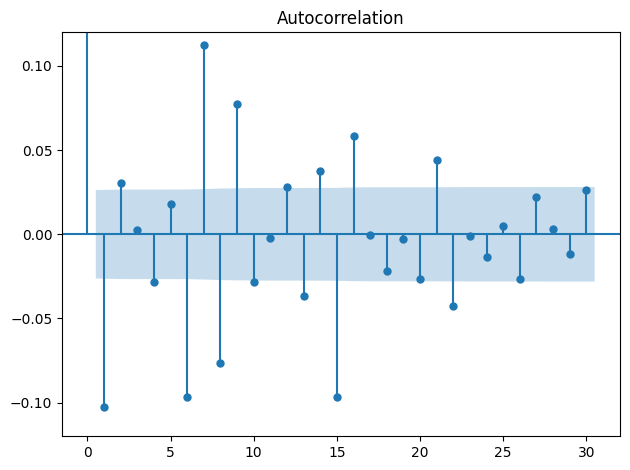

In [15]:
# Plot ACF to check for correlation - Zoom

plot_acf(first_order_diff, lags=30)

plt.ylim(-0.12, 0.12)

plt.tight_layout()

Stationary but not fully uncorrelated, quite though

ES cannot be approximated as a random walk process, because it shows several significant coefficients

In [16]:
train = df[:-5]
test = df[-5:]

In [17]:
# Predict the historical mean

mean = np.mean(train['Close'])

test.loc[:, 'pred_mean'] = mean

test.head()

,Date,Close,pred_mean
5549,2022-07-05,3834.00,1833.679632
5550,2022-07-06,3848.25,1833.679632
5551,2022-07-07,3905.00,1833.679632
5552,2022-07-08,3901.25,1833.679632
5553,2022-07-11,3856.75,1833.679632


In [18]:
# Predict the last value

last_value = train['Close'].iloc[-1]

test.loc[:, 'pred_last'] = last_value

test.head()

,Date,Close,pred_mean,pred_last
5549,2022-07-05,3834.00,1833.679632,3830.625
5550,2022-07-06,3848.25,1833.679632,3830.625
5551,2022-07-07,3905.00,1833.679632,3830.625
5552,2022-07-08,3901.25,1833.679632,3830.625
5553,2022-07-11,3856.75,1833.679632,3830.625


In [19]:
# Predict with the drift method
# Drift method: same historical average rate of change, same historical slope

deltaX = len(train) - 1
deltaY = last_value - train['Close'].iloc[0]

drift = deltaY / deltaX

x_vals = np.arange(5549, 5554, 1)

pred_drift = drift * x_vals + train['Close'].iloc[0]

test.loc[:, 'pred_drift'] = pred_drift

test.head()

,Date,Close,pred_mean,pred_last,pred_drift
5549,2022-07-05,3834.00,1833.679632,3830.625,3831.048959
5550,2022-07-06,3848.25,1833.679632,3830.625,3831.472918
5551,2022-07-07,3905.00,1833.679632,3830.625,3831.896877
5552,2022-07-08,3901.25,1833.679632,3830.625,3832.320836
5553,2022-07-11,3856.75,1833.679632,3830.625,3832.744795


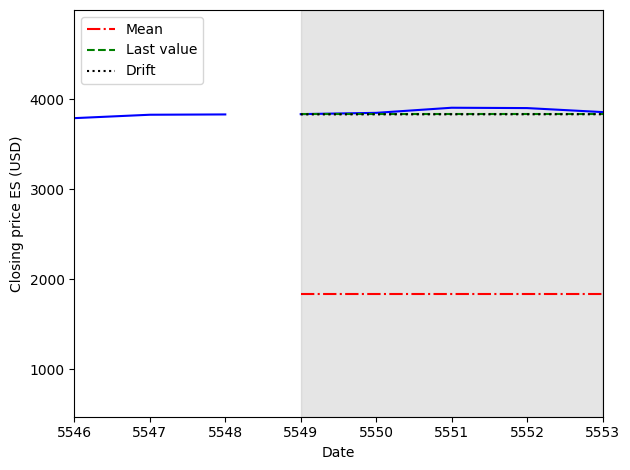

In [20]:
# Plot forecasts by naive methods

fig, ax = plt.subplots()

ax.plot(train['Close'], 'b-')
ax.plot(test['Close'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['pred_last'], 'g--', label='Last value')
ax.plot(test['pred_drift'], 'k:', label='Drift')

ax.axvspan(5549, 5553, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Date')
ax.set_ylabel('Closing price ES (USD)')

#ax.set_xlim(5540, 5553)
plt.xlim(5546, 5553)

plt.tight_layout()

In [21]:
# MSE of predictions

from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['Close'], test['pred_mean'])
mse_last = mean_squared_error(test['Close'], test['pred_last'])
mse_drift = mean_squared_error(test['Close'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

4143560.868441783 2304.815625 2192.345024535731


##### Forecasting the next timestep 

Specifically, we will predict the last known value

In [22]:
df_shift = df.shift(periods=1)

df_shift.head()

,Date,Close
0,NaT,NaN
1,2000-09-19,1478.5
2,2000-09-20,1469.5
3,2000-09-21,1469.5
4,2000-09-22,1468.5


In [23]:
# Pg 54, MSE of the prediction of the test set

mse_one_step = mean_squared_error(test['Close'], df_shift['Close'][-5:])

mse_one_step

1085.865625

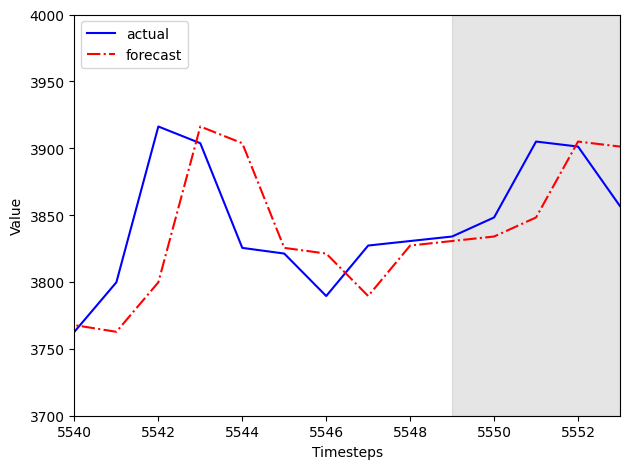

In [27]:
fig, ax = plt.subplots()

ax.plot(df['Close'], 'b-', label='actual')
ax.plot(df_shift['Close'], 'r-.', label='forecast')

ax.axvspan(5549, 5553, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlim(5540, 5553)
ax.set_ylim(3700, 4000)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()